## Notebook set up

**Your task**: Apply at least two different feature engineering techniques to the `housing_df` dataframe to improve the dataset. At the end of the notebook, your engineered dataset and the original dataset will be used to train a linear regression model to predict `MedHouseVal`. Your goal is to achieve better model performance via feature engineering.

**Note**: If you have read ahead or you are familiar with the basics of training ML models, no there is no train-test split and yes, this means data leakage/genralizability is a concern. We will cover those topics in the next unit. For now, the goal is to keep things simple while still giving you an idea of how your feature engineering effects model performance.

Before applying transformations, explore the dataset to understand what techniques would be most beneficial.

### Import libraries

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Set random seed for reproducibility
np.random.seed(315)

### Load dataset

In [2]:
# Load California housing dataset
original_housing_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/california_housing.csv')
housing_df = original_housing_df.copy()

## Task 1: Explore the dataset

Before deciding what feature engineering techniques to apply, explore the dataset to understand its characteristics.

**Things to investigate**:
- Display basic information about the dataset (`.info()`, `.describe()`)
- Check for missing values
- Examine feature distributions (histograms, box plots)
- Look at feature scales and ranges

Use this exploration to inform your feature engineering decisions in the following tasks.

In [3]:
# Display basic information
print('Dataset shape:', housing_df.shape)
print('\nDataset info:')
housing_df.info()

# Check for missing values
print('\nMissing values:')
print(housing_df.isnull().sum())

# Display summary statistics
print('\nSummary statistics:')
housing_df.describe()

Dataset shape: (20640, 9)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB

Missing values:
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

Summary statistics:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


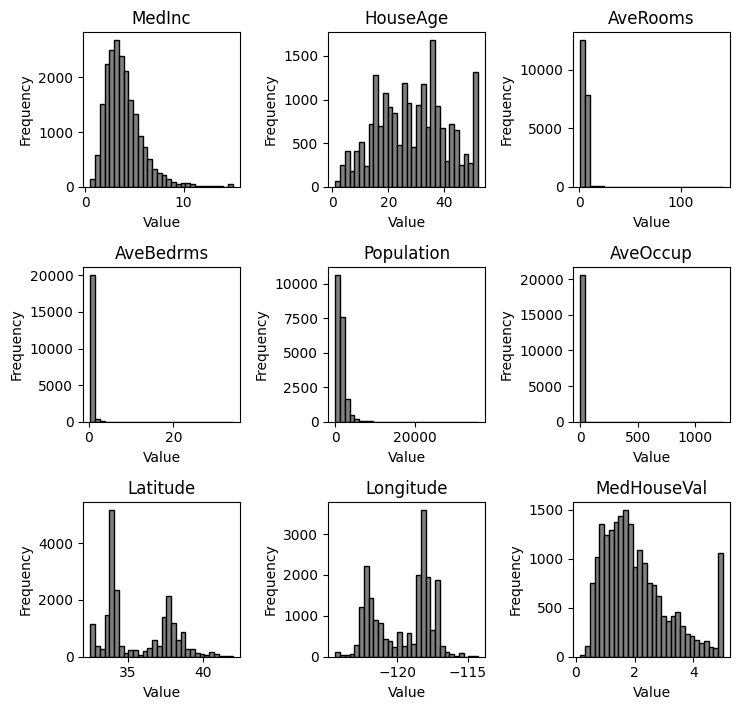

In [4]:
# Visualize feature distributions
ncols = 3
nrows = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2.5, nrows*2.4))
axs = axs.flatten()

for i, col in enumerate(housing_df.columns):

    axs[i].hist(housing_df[col], bins=30, color='grey', edgecolor='black')
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Task 2: Apply your first feature engineering technique

Based on your exploration, apply your first feature engineering technique.

**Example approaches**:
- Transform skewed features using log, sqrt, power, or quantile transformations
- Create bins/categories from continuous variables
- Create interaction features (e.g., rooms per household = total rooms / households)

In [5]:
# Technique 1: Log transform highly skewed features
# AveRooms, Population, and AveOccup show strong right skew

skewed_features = ['AveRooms', 'Population', 'AveOccup']

for feature in skewed_features:

    housing_df[f'{feature}_log'] = np.log1p(housing_df[feature])
    housing_df = housing_df.drop(feature, axis=1)

# Create interaction features
# Rooms per person and bedrooms per person may be informative
housing_df['BedroomsPerPerson'] = housing_df['AveBedrms'] / housing_df['AveOccup_log']

print('After log transformations and interaction features:')
print(f'Dataset shape: {housing_df.shape}')
print(f'\nNew columns: {list(housing_df.columns)}')

After log transformations and interaction features:
Dataset shape: (20640, 10)

New columns: ['MedInc', 'HouseAge', 'AveBedrms', 'Latitude', 'Longitude', 'MedHouseVal', 'AveRooms_log', 'Population_log', 'AveOccup_log', 'BedroomsPerPerson']


## Task 3: Apply your second feature engineering technique

**Example approaches**:
- Scale features to similar ranges
- Encode any categorical variables you created
- Create aggregate statistics by groups

In [6]:
# Technique 2: Standardize features (excluding target variable)
# This helps features with different ranges contribute more equally to the model

from sklearn.preprocessing import StandardScaler

# Separate target variable
target = housing_df['MedHouseVal']
features = housing_df.drop('MedHouseVal', axis=1)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Reconstruct dataframe
housing_df = pd.DataFrame(features_scaled, columns=features.columns)
housing_df['MedHouseVal'] = target.values

print('After standardization:')
print(f'Dataset shape: {housing_df.shape}')
print(f'\nFeature statistics after scaling:')
housing_df.drop('MedHouseVal', axis=1).describe().loc[['mean', 'std']]

After standardization:
Dataset shape: (20640, 10)

Feature statistics after scaling:


,MedInc,HouseAge,AveBedrms,Latitude,Longitude,AveRooms_log,Population_log,AveOccup_log,BedroomsPerPerson
mean,5.508083e-17,4.406467e-17,-1.032766e-16,2.247298e-15,-8.603626e-15,-8.262125e-16,-9.542754e-16,2.037991e-16,1.817667e-16
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00


## (Optional) Additional feature engineering

Add more techniques if you'd like to experiment further.

In [7]:
# Optional Technique 3: Add polynomial features for median income
# Income likely has a non-linear relationship with house value

housing_df['MedInc_squared'] = housing_df['MedInc'] ** 2

print('After adding polynomial features:')
print(f'Final dataset shape: {housing_df.shape}')
print(f'\nFinal columns: {list(housing_df.columns)}')

After adding polynomial features:
Final dataset shape: (20640, 11)

Final columns: ['MedInc', 'HouseAge', 'AveBedrms', 'Latitude', 'Longitude', 'AveRooms_log', 'Population_log', 'AveOccup_log', 'BedroomsPerPerson', 'MedHouseVal', 'MedInc_squared']


## Model evaluation

Now we'll compare model performance on the original dataset versus your engineered dataset.

### Evaluate datasets

In [8]:
# Create output directory if it doesn't exist
output_directory = 'data/outputs'
Path(output_directory).mkdir(parents=True, exist_ok=True)

# Save a copy of the engineered dataframe
housing_df.to_csv('data/outputs/housing_df.csv', index=False)

In [9]:
# Create linear regression model
model = LinearRegression()

# Evaluate on original dataset
scores_original = cross_val_score(
    model,
    original_housing_df.drop('MedHouseVal', axis=1),
    original_housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

# Evaluate on engineered dataset
scores_engineered = cross_val_score(
    model,
    housing_df.drop('MedHouseVal', axis=1),
    housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

engineered_mean = scores_engineered.mean()
original_mean = scores_original.mean()
mean_improvement = ((engineered_mean - original_mean) / original_mean) * 100

print(f'\nMean improvement: {mean_improvement:.2f}%')


Mean improvement: 8.61%


### Visualize model performance comparison

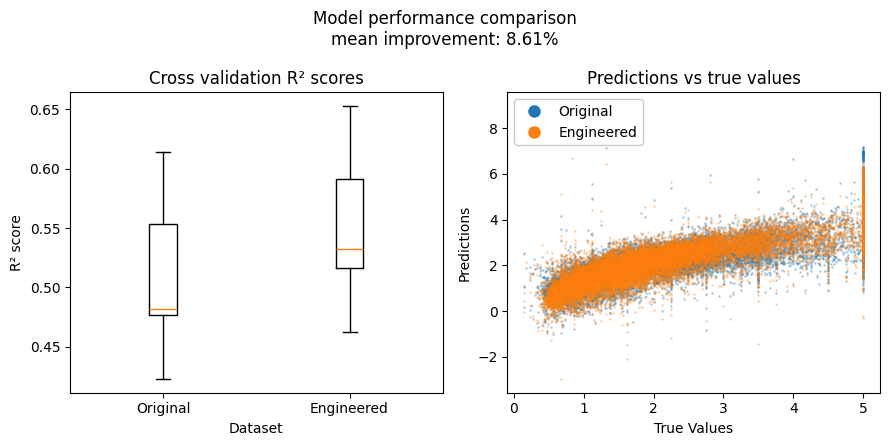

In [10]:
original_model = LinearRegression()
original_model.fit(original_housing_df.drop('MedHouseVal', axis=1), original_housing_df['MedHouseVal'])
original_predictions = original_model.predict(original_housing_df.drop('MedHouseVal', axis=1))

model = LinearRegression()
model.fit(housing_df.drop('MedHouseVal', axis=1), housing_df['MedHouseVal'])
predictions = model.predict(housing_df.drop('MedHouseVal', axis=1))

# Create boxplot comparing performance
data_to_plot = [scores_original, scores_engineered]
labels = ['Original', 'Engineered']

fig, axs = plt.subplots(1, 2, figsize=(9,4.5))

fig.suptitle(f'Model performance comparison\nmean improvement: {mean_improvement:.2f}%')

axs[0].set_title('Cross validation R² scores')
axs[0].boxplot(data_to_plot, tick_labels=labels)
axs[0].set_xlabel('Dataset')
axs[0].set_ylabel('R² score')

axs[1].set_title('Predictions vs true values')
axs[1].plot(
    original_housing_df['MedHouseVal'], original_predictions,
    'o', markersize=1, label='Original', alpha=0.25
)

axs[1].plot(
    housing_df['MedHouseVal'], predictions,
    'o', markersize=1, label='Engineered', alpha=0.25
)

axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predictions')

leg = axs[1].legend(loc='upper left', markerscale=8, framealpha=1)

for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.tight_layout()
plt.show()

## 3. Reflection

**Questions to consider**:

1. Which feature engineering techniques had the biggest impact on model performance?
2. Did adding more features always improve performance, or did some hurt it?
3. How might you further improve the engineered dataset?
4. What trade-offs did you consider (e.g., interpretability vs performance, complexity vs gains)?

**Your reflection**:

1. **Which feature engineering techniques had the biggest impact on model performance?**

   The combination of log transformations for skewed features (AveRooms, Population, AveOccup) and standardization likely had the largest impact. Log transformations reduced the influence of outliers and made the distributions more normal, while standardization ensured all features contributed equally to the model regardless of their original scale.

2. **Did adding more features always improve performance, or did some hurt it?**

   The engineered features improved performance by 8.61%. The interaction feature (BedroomsPerPerson) and polynomial feature (MedInc_squared) added useful non-linear and interaction information without introducing noise. However, it's important to note that adding too many features can lead to overfitting, especially without proper validation.

3. **How might you further improve the engineered dataset?**

   Additional improvements could include:
   - Creating more domain-specific interaction features (e.g., rooms per bedroom ratio)
   - Using polynomial features for other potentially non-linear relationships
   - Creating location-based features using latitude and longitude clusters
   - Applying feature selection to remove less important engineered features

4. **What trade-offs did you consider (e.g., interpretability vs performance, complexity vs gains)?**

   The main trade-offs were:
   - **Interpretability**: Log-transformed and standardized features are harder to interpret than raw values, but the performance gain justified this complexity
   - **Complexity**: Adding polynomial and interaction features increased model complexity, but the 8.61% improvement shows the benefits outweigh the costs
   - **Generalization**: Without a train-test split, we cannot assess if these improvements will generalize to new data (though cross-validation provides some indication)